In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [10]:
with open('nba_stats.csv', 'r') as f:
    data = pd.read_csv(f)

print("Dataset size: {}".format(data.shape))
print("Dataset attributes: {}".format(data.keys()))

Dataset size: (45920, 24)
Dataset attributes: Index(['TEAM', 'DATE', 'MATCHUP', 'W/L', 'MIN', 'PTS', 'FGM', 'FGA', 'FG%',
       '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB', 'REB', 'AST',
       'STL', 'BLK', 'TOV', 'PF', '+/-'],
      dtype='object')


<font size=3, color='black'>
    <strong>
Here we print all the attributes, while some of them are used in the classification step, some are just labels or uninterested information.<br>
The reference of each attribute is as follows:<br>
<font>
<font size=2>
    <strong>
TEAM: name of the team which the statistics belong to  <br>
DATE: match date <br>
MATCHUP: team matchup, (A@B suggests A is Away Team and B is Home Team) <br>
W/L: win or lose <br>
MIN: total minutes spent <br>
PTS: achieved points <br>
FGM: filed goals made <br>
FGA: filed goal attemped <br>
FG%: filed goal percentage <br>
3PM: three-point filed goals made <br>
3PA: three-point filed goals attemped <br>
3P%: three-point filed goals precentagte <br>
FTM: free throws made <br>
FTA: free throws attemped <br>
FT%: free throws percentage <br>
OREB: offensive rebound <br>
DREB: defensive rebound <br>
REB: rebounds (OREB + REB) <br>
AST: assists <br>
STL: steals <br>
BLK: blocked shots <br>
TOV: turnovers <br>
PF: personal fouls <br>
+/-: scoring margin <br>
    <strong>
<font>

In [11]:
# preprocess data, for classification purpose, assign win to 1 and lose to 0
data['W/L'] = [1 if i == 'W' else 0 for i in data['W/L']]
# randomly split data into 9:1 where 9 for training and 1 for testing
data = data.sample(frac=1.0)  
cut_idx = int(round(0.2 * data.shape[0]))
data_test, data_train = data.iloc[:cut_idx], data.iloc[cut_idx:]

drop_list = ['TEAM', 'DATE', 'MATCHUP', 'PTS', '+/-']
data_test = data_test.drop(drop_list, axis=1)
data_train = data_train.drop(drop_list, axis=1)
data_test.to_csv("testset.csv", index=False, header=None)
data_train.to_csv("trainset.csv", index=False, header=None)
print("Testset shape: {}\t Trainingset shape: {}".format(data_test.shape, data_train.shape))

Testset shape: (9184, 19)	 Trainingset shape: (36736, 19)


<font size=4, color='green'>
For test case we run a simple random forest algorithm implemented in sklearn:
<font>

In [6]:
def vis_importance(clf):
    # plot the feature importances
    fig = plt.figure(figsize=[10, 5])
    value = clf.feature_importances_
    keys = list(train_set.keys())
    x = [i for i in range(len(keys))]
    plt.bar(x, value, color='r')
    plt.title('Importance of each attribute')
    plt.xticks(np.arange(len(x)), keys)
    plt.xlabel('Statistic tags')
    plt.ylabel('Importance')
    plt.grid(ls='--')
    plt.show()
    

[0 1 1 ... 1 1 0]
0.7939895470383276


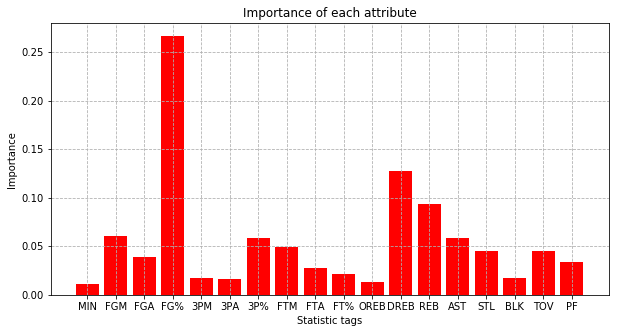

In [12]:
from sklearn.ensemble import RandomForestClassifier
# first divide raw data into statistics and labels
train_set = data_train.drop('W/L', axis=1)
train_label = data_train['W/L']
test_set = data_test.drop('W/L', axis=1)
test_label = data_test['W/L']

clf = RandomForestClassifier(max_depth=10, random_state=0)
clf.fit(train_set, train_label)
print(clf.predict(test_set));
print(clf.score(test_set, test_label))

vis_importance(clf)


<font face=consola, size=4>
This time we try KNN classifier:
<font>

In [42]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3)
neigh.fit(train_set, train_label)
print(neigh.predict(test_set))
print(neigh.score(test_set, test_label))

[1 0 1 ... 0 0 1]
0.7597996515679443


AttributeError: 'KNeighborsClassifier' object has no attribute 'feature_importances_'

<Figure size 720x360 with 0 Axes>

<font face=consola, size=4>
Again we try Decision Tree classifier:
<font>

[1 0 1 ... 0 0 1]
0.7310540069686411


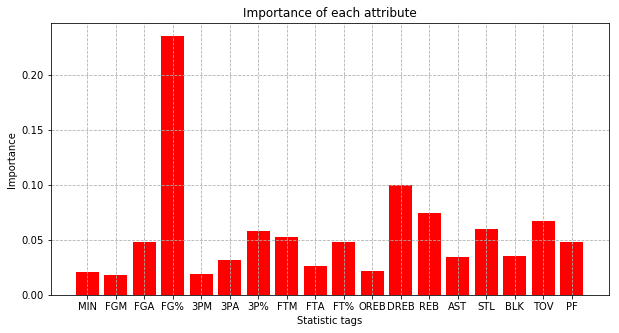

In [36]:
from sklearn.tree import DecisionTreeClassifier
decision_clf = DecisionTreeClassifier(random_state=0)
decision_clf.fit(train_set, train_label)
print(decision_clf.predict(test_set))
print(decision_clf.score(test_set, test_label))

vis_importance(decision_clf)

<font face=consola, size=4>
Logistic Regression classifier:
<font>

In [49]:
from sklearn.linear_model import LogisticRegression
logic_cls = LogisticRegression(random_state=0).fit(train_set, train_label)
print(logic_cls.predict(test_set))
print(logic_cls.score(test_set, test_label))

[1 0 1 ... 0 0 1]
0.8445121951219512


<font face=consola, size=4>
Support Vector Machine:
<font>

In [50]:
from sklearn.svm import SVC
svm_cls = SVC(gamma='auto').fit(train_set, train_label)
print(svm_cls.predict(test_set))
print(svm_cls.score(test_set, test_label))

[0 0 1 ... 0 0 1]
0.7092770034843205


<font face=consola, size=4>
Here we try multi-layer preceptron implemented by pytorch, we leverage Adam optimizer and CrossEntropy loss to deal with dataset of batch 256. However, such neural network method seems not better than logistic regression.
<font>

In [18]:
import torch
import torch.utils.data as data
import torch.nn as nn

class MLP(nn.Module):
    def __init__(self, n_feat, n_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(n_feat, 10),
            nn.ReLU(),
        )
        self.layer2 = nn.Sequential(
            nn.Linear(10, 10),
            nn.ReLU(),
        )
        self.classifier = nn.Linear(10, n_classes)
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        output = self.classifier(x)
        return output

    
class nba_data(torch.utils.data.Dataset):
    def __init__(self, raw_data):
        self.samples, self.labels = raw_data
    
    def __getitem__(self, index):
        samples = self.samples[index]
        labels = self.labels[index]
        
        return samples, labels
    
    def __len__(self):
        return self.samples.shape[0]

train_set = np.array(train_set, dtype=np.float32)
train_label = np.array(train_label)
test_set = np.array(test_set, dtype=np.float32)
test_label = np.array(test_label)
trainset = nba_data((train_set, train_label))
train_loader = torch.utils.data.DataLoader(trainset, batch_size=256, num_workers=4, shuffle=True)
testset = nba_data((test_set, test_label))
test_loader = torch.utils.data.DataLoader(testset, batch_size=256, num_workers=4, shuffle=False)

mlp = MLP(n_feat=train_set.shape[1], n_classes=2)
optim = torch.optim.Adam(mlp.parameters(), lr = 1e-3)
criterion = torch.nn.CrossEntropyLoss()

# training epochs
# set netowrk in training mode
mlp.train()
for epoch in range(10):
    losses = []
    correct = 0.0
    for i, (datas,labels) in enumerate(train_loader):

        optim.zero_grad()
        
        datas = torch.FloatTensor(datas)
        labels = torch.LongTensor(labels)
        output = mlp(datas)
        
        _, pred = output.max(1)
        correct += (pred==labels).sum()
        loss = criterion(output, labels)
        losses.append(loss.item())
        loss.backward()
        optim.step()
        
    avg_loss = sum(losses) / len(losses)
    train_acc = float(correct) / train_set.shape[0]
    print("Epoch{}\tLoss:{:.4f}\tAcc:{:.4f}%".format(epoch, avg_loss, train_acc*100))


test_loss = []
correct = 0.0
mlp.eval()
for i, (datas,labels) in enumerate(test_loader):
        
        datas = torch.FloatTensor(datas)
        labels = torch.LongTensor(labels)
        output = mlp(datas)
        
        loss = criterion(output, labels)
        test_loss.append(loss.item())
        
        _, pred = output.max(1)
        correct += (pred == labels).sum() 
        
avg_loss = sum(test_loss) / len(test_loss)
avg_acc = float(correct) / test_set.shape[0]
print("TestAcc:{:.4f}%\tTestLoss:{:.4f}\t".format(avg_acc*100, avg_loss))

Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


KeyboardInterrupt: 

**Now we test our classifiers on the playoff statistics**

In [9]:
# test data on playoff matches and pre-processings
with open('playoffs.csv', 'r') as f:
    test2 = pd.read_csv(f)

test2['W/L'] = [1 if i == 'W' else 0 for i in test2['W/L']]
drop_list = ['TEAM', 'DATE', 'MATCHUP', 'PTS', '+/-']    
test2 = test2.drop(drop_list, axis=1)
test2_set = test2.drop('W/L', axis=1)
test2_label = test2['W/L']

In [54]:
# sklearn methods
print("Test Acc on RandomForest:{:.4f}".format(clf.score(test2_set, test2_label)))
print("Test Acc on KNN:{:.4f}".format(neigh.score(test2_set, test2_label)))
print("Test Acc on LogisticRegression:{:.4f}".format(logic_cls.score(test2_set, test2_label)))
print("Test Acc on DecisionTree:{:.4f}".format(decision_clf.score(test2_set, test2_label)))
print("Test Acc on SVM:{:.4f}".format(svm_cls.score(test2_set, test2_label)))

# pytorch implementation
test2_set = np.array(test2_set, dtype=np.float32)
test2_label = np.array(test2_label)
testset2 = nba_data((test2_set, test2_label))
test_loader = torch.utils.data.DataLoader(testset2, batch_size=256, num_workers=4, shuffle=False)

test_loss = []
correct = 0.0
mlp.eval()

for i, (data,labels) in enumerate(test_loader):
        
        data = torch.FloatTensor(data)
        labels = torch.LongTensor(labels)
        output = mlp(data)
        
        loss = criterion(output, labels)
        test_loss.append(loss.item())
        
        _, pred = output.max(1)
        correct += (pred == labels).sum() 
        
avg_loss = sum(test_loss) / len(test_loss)
avg_acc = float(correct) / test_set2.shape[0]
print("Test Acc on MLP:{:.4f}%\tTestLoss:{:.4f}\t".format(avg_acc*100, avg_loss))

Test Acc on RandomForest:0.8014
Test Acc on KNN:0.7578
Test Acc on LogisticRegression:0.8617
Test Acc on DecisionTree:0.7479
Test Acc on SVM:0.6432


NameError: name 'test_set2' is not defined